# Week 3
## Data Preprocessing

In this task, we will Pre-Process the given datasets.

In [272]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from models import LinRegNormEq

In [273]:
airq = pd.read_csv('data/airq402.csv')
wine_red = pd.read_csv('data/winequality-red.csv', sep=';')
wine_white = pd.read_csv('data/winequality-white.csv', sep=';')

Before we start with the exercise, we rename the columns of the airq dataset according to https://users.stat.ufl.edu/~winner/data/airq402.txt

In [274]:
airq.columns = [
    "City1",  # Origin city
    "City2",  # Destination city
    "Average_Fare",  # Average fare (USD)
    "Distance",  # Distance (miles)
    "Avg_Weekly_Passengers",  # Average weekly passengers
    "Leading_Airline",  # Market leading airline
    "Leading_Share",  # Market share of leading airline (%)
    "Leading_Fare",  # Average fare for leading airline (USD)
    "Low_Price_Airline",  # Low price airline
    "Low_Price_Share",  # Market share of low price airline (%)
    "Low_Price_Fare"  # Price for low price airline (USD)
]

Now, we start with the exercise and convert all values to numeric values using `pandas.get_dummies`. For the airq dataset, we use pd.get_dummies() to "convert every categorical variable into indicator variable. Each variable is converted in as many 0/1 variables as there are different values. Columns in the output are each named after a value; if the input is a DataFrame, the name of the original variable is prepended to the value" (https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html#pandas.get_dummies).
This gives us the one-hot encoding required according to the question.


In [275]:
airq = pd.get_dummies(airq).astype(np.float64)

We handle sparse data / missing values. Looking over the datasets by eye, we do not see any missing values. Since we have quite large datasets and, we can just drop the columns with missing values. As we can see from the execution, there are actually no missing values in the dataset.

In [276]:
print(f'len of winequality_red before: {len(wine_red)}')
wine_red = wine_red.dropna()
print(f'len of winequality_red after: {len(wine_red)}\n')

print(f'len of winequality_white before: {len(wine_white)}')
wine_white = wine_white.dropna()
print(f'len of winequality_white after: {len(wine_white)}\n')

print(f'len of airq before: {len(airq)}')
airq = airq.dropna()
print(f'len of winequality_white after: {len(airq)}\n')

len of winequality_red before: 1599
len of winequality_red after: 1599

len of winequality_white before: 4898
len of winequality_white after: 4898

len of airq before: 1000
len of winequality_white after: 1000



We use `pandas.DataFrame.sample` like last week to split the datasets in training data and test data.

In [277]:
airq_train = airq.sample(frac=0.8, random_state=69)
airq_test = airq.drop(airq_train.index)

wine_red_train = wine_red.sample(frac=0.8, random_state=42)
wine_red_test = wine_red.drop(wine_red_train.index)

wine_white_train = wine_white.sample(frac=0.8, random_state=420)
wine_white_test = wine_white.drop(wine_white_train.index)

airq_train

,Average_Fare,Distance,Avg_Weekly_Passengers,Leading_Share,Leading_Fare,Low_Price_Share,Low_Price_Fare,City1_ABQ,City1_ACY,City1_ALB,...,Low_Price_Airline_G4,Low_Price_Airline_HP,Low_Price_Airline_NK,Low_Price_Airline_NW,Low_Price_Airline_SY,Low_Price_Airline_TZ,Low_Price_Airline_UA,Low_Price_Airline_US,Low_Price_Airline_WN,Low_Price_Airline_YX
823,194.05,2430.0,482.50,46.11,172.15,14.77,170.19,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999,126.67,859.0,475.65,56.28,129.92,38.57,121.94,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
891,170.12,2553.0,528.26,27.20,171.30,21.17,152.32,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
781,212.02,981.0,262.82,63.64,232.88,6.24,142.09,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
967,142.71,599.0,404.78,63.10,146.29,33.83,133.85,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,180.26,833.0,217.71,49.52,168.73,49.52,168.73,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
765,180.50,297.0,362.39,96.85,180.71,96.85,180.71,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
193,236.58,1609.0,667.17,68.01,242.92,68.01,242.92,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,122.38,914.0,208.36,95.77,122.40,95.77,122.40,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Linear Regression with Gradient Descent

In this task, we implement a linear regression algorithm with gradient descent.


In [278]:
class LinRegGradDesc:
    def __init__(self):
        self.B = None

    def fit(self, X, y, alpha=0.01, i_max=550, epsilon=0.001):
        """
        Learn Linear Regression via Loss Minimization via Gradient Descent.
        :param X: Input features.
        :param y: Target values.
        :param alpha: Step length.
        :param i_max: Maximum number of iterations.
        :param epsilon: Convergence threshold.
        :return: None
        """

        f = lambda B: ((y - X @ B).T @ (y - X @ B))
        B_0 = np.zeros((X.shape[1], 1))
        self.B = self._minimize_gd(f, X, y, B_0, alpha=alpha, i_max=i_max, epsilon=epsilon)

    def predict(self, X):
        """
        Predict using the linear regression model.
        :param X: Input features to predict values for.
        :return: Predicted values.
        """
        if self.B is None:
            raise ValueError("The model has not been trained yet. Please call fit() first.")

        return (X @ self.B).reshape(-1, 1)

    def _loss(self, X, y):
        """
        Loss function via least squares loss.
        :param X: Input features.
        :param y: Target values.
        :return: Computed loss.
        """
        y_pred = self.predict(X)
        return ((y - y_pred) ** 2).sum()

    @staticmethod
    def _minimize_gd(f, X, y, x_0, alpha, i_max, epsilon, clip_value=1.0):
        """
        Minimize loss using gradient descent.
        :param f: Loss function.
        :param alpha: Step length function.
        :param i_max: Maximum number of iterations.
        :param epsilon: Convergence threshold.
        :return: Optimal weights.
        """

        x_i = x_0

        for i in range(1, i_max + 1):
            # grad_approx = np.zeros_like(x_i)
            # h = 1e-8
            # for j in range(len(x_i)):
            #     x_ij = np.copy(x_i)
            #     x_ij[j] += h
            #     grad_approx[j] = (f(x_ij) - f(x_i)) / h
            # d = -grad_approx
            d = 2 * X.T @ (y - X @ x_i) / len(y)  # Analytical Gradient

            # handle gradient clipping
            d_norm = np.linalg.norm(d)
            if d_norm > clip_value:
                d = (d / d_norm) * clip_value

            if callable(alpha):
                alpha_i = alpha(f, x_i, d)
            else:
                alpha_i = alpha

            x_i_new = x_i + alpha_i * d

            print(f(x_i) - f(x_i_new))

            if np.abs(f(x_i) - f(x_i_new)) < epsilon:
                print(f'Converged in {i} iterations.')
                return x_i_new

            x_i = x_i_new

        # raise ValueError(f'Did not converge in {i_max} iterations')

        print(f'Did not converge in {i_max} iterations')
        return x_i

    @staticmethod
    def armijo(f, x, d, delta=0.2):
        """
        Armijo step length function.
        :param f: Loss function.
        :param x: Last position.
        :param d: Descent directions.
        :param delta: Minimum steepness
        :return: Step length alpha.
        """
        alpha = 1

        while f(x) - f(x + alpha * d) < alpha * delta * d.T @ d:
            alpha /= 2

        return alpha

[[19204314.24224657]]
[[546198.75027801]]
[[296743.64770001]]
[[97011.81825669]]
[[26593.33038952]]
[[85994.8572109]]
[[42006.70585193]]
[[70163.37213335]]
[[48258.60596182]]
[[61841.36671839]]
[[50266.02048144]]
[[56800.05340911]]
[[50292.38366717]]
[[53319.99266345]]
[[49391.87165034]]
[[50632.88451148]]
[[48064.38783766]]
[[48377.22486667]]
[[46551.61782565]]
[[46376.04404747]]
[[44972.60491565]]
[[44539.48467522]]
[[43386.8630207]]
[[42820.15965407]]
[[41824.35368624]]
[[41191.99071281]]
[[40300.04188445]]
[[39639.88397039]]
[[38821.12519489]]
[[38154.56021802]]
[[37390.70509036]]
[[36729.90306059]]
[[36009.69194587]]
[[35361.56716524]]
[[34677.81401183]]
[[34046.23161869]]
[[33394.16219431]]
[[32781.19069595]]
[[32157.48946223]]
[[31564.12473778]]
[[30966.37802315]]
[[30392.96906111]]
[[29819.33391744]]
[[29265.83723789]]
[[28714.84107164]]
[[28180.9750778]]
[[27651.39233236]]
[[27136.73226006]]
[[26627.50722804]]
[[26131.5442889]]
[[25641.74197062]]
[[25163.92059432]]
[[24692.694

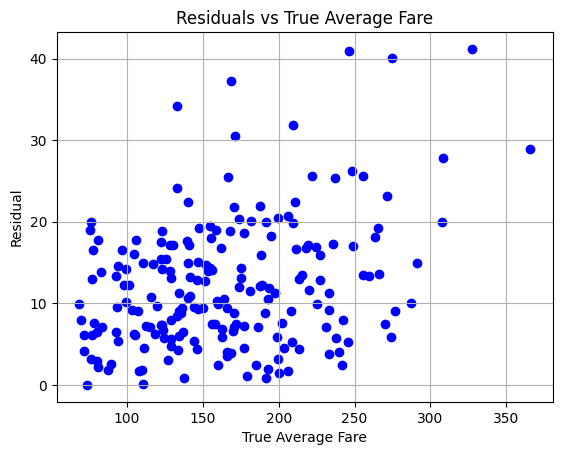

In [283]:
model = LinRegGradDesc()

# Convert training data to numpy arrays
Xdata = airq_train.drop('Average_Fare', axis=1).to_numpy()
Ydata = airq_train['Average_Fare'].to_numpy().reshape(-1, 1)

# Fit the model on training data
model.fit(Xdata, Ydata, alpha=LinRegGradDesc.armijo, i_max=10000, epsilon=0.1)

# Convert test data to numpy arrays for prediction
Xtest = airq_test.drop('Average_Fare', axis=1).to_numpy()

# Get predictions
airq_predictions = model.predict(Xtest).ravel()

# Calculate residuals (absolute differences between true values and predictions)
residuals = np.abs(airq_test['Average_Fare'].to_numpy() - airq_predictions)

# Print the shapes to verify they match
print(f'Shape of predictions: {airq_predictions.shape}')
print(f'Shape of residuals: {residuals.shape}')

# Scatter plot of true Average_Fare vs. residuals
plt.scatter(airq_test['Average_Fare'], residuals, color='blue')
plt.xlabel('True Average Fare')
plt.ylabel('Residual')
plt.title('Residuals vs True Average Fare')
plt.grid(True)
plt.show()
plt.close()